# Lab Solution: Early Stopping and Training Monitoring

## Introduction

You've recently joined HealthTech Analytics, a healthcare AI startup that's developing systems to predict patient readmission risk based on electronic health records. As a junior data scientist, you've been tasked with implementing a neural network model, which has been showing promising results but has inconsistent performance.

Your manager explains that the model sometimes performs well, but other times it overfits to training data or fails to converge properly. She suspects that proper training monitoring and early stopping strategies might solve these issues, making the model more reliable for clinical applications.

The Chief Data Officer has emphasized that the company can't afford to waste computational resources on models that aren't learning effectively, and clinical staff need stable, reliable predictions. You'll need to implement proper training monitoring and callbacks to ensure the model trains efficiently and generalizes well to new patient data.

## Part 0: Import Libraries and Set Up Environment

In [2]:
# Import necessary libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.keras.optimizers import Adam

from sklearn.preprocessing import StandardScaler, OneHotEncoder, TargetEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os

# Set random seeds for reproducibility
import random
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

## Part 1: Load and Explore Dataset

The dataset contains information from diabetic patients with various features such as age, gender, lab results, medical history, and a target variable indicating whether the patient was readmitted within 30 days, after 30 days, or not at all.

In [4]:
# Load in Data
patient_data = pd.read_csv(
    "readmission_data.csv",
    na_values=["?", "Unknown/Invalid", "UNK", "None", "NA", "NaN", ""]
)
patient_data.info()
patient_data.head()

C:\Users\jewbo\AppData\Local\Temp\ipykernel_11528\1333890069.py:2: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  patient_data = pd.read_csv(


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      99493 non-null   object
 3   gender                    101763 non-null  object
 4   age                       101766 non-null  object
 5   weight                    3197 non-null    object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                61510 non-null   object
 11  medical_specialty         51817 non-null   object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),NaN,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),NaN,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),NaN,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),NaN,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),NaN,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


Dataset shape: (101766, 50)
Readmission rate: readmitted
NO     0.539119
>30    0.349282
<30    0.111599
Name: proportion, dtype: float64


Text(0.5, 1.0, 'Distribution of Readmissions')

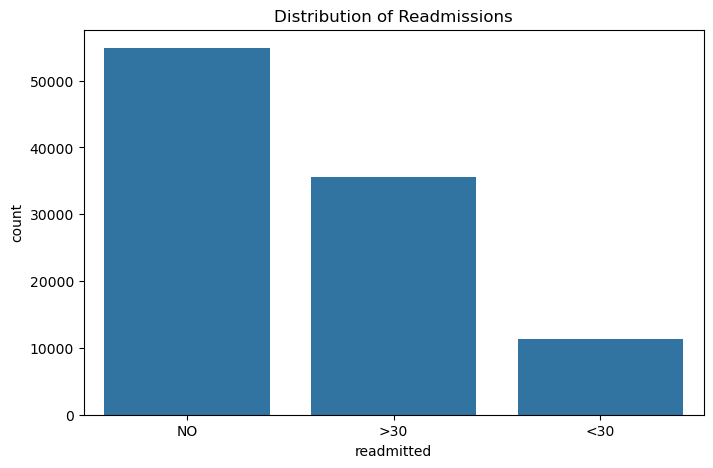

In [5]:
# Let's explore the dataset
print(f"Dataset shape: {patient_data.shape}")
print(f"Readmission rate: {patient_data['readmitted'].value_counts(normalize=True)}")

# Check class balance
plt.figure(figsize=(8, 5))
sns.countplot(x='readmitted', data=patient_data)
plt.title('Distribution of Readmissions')

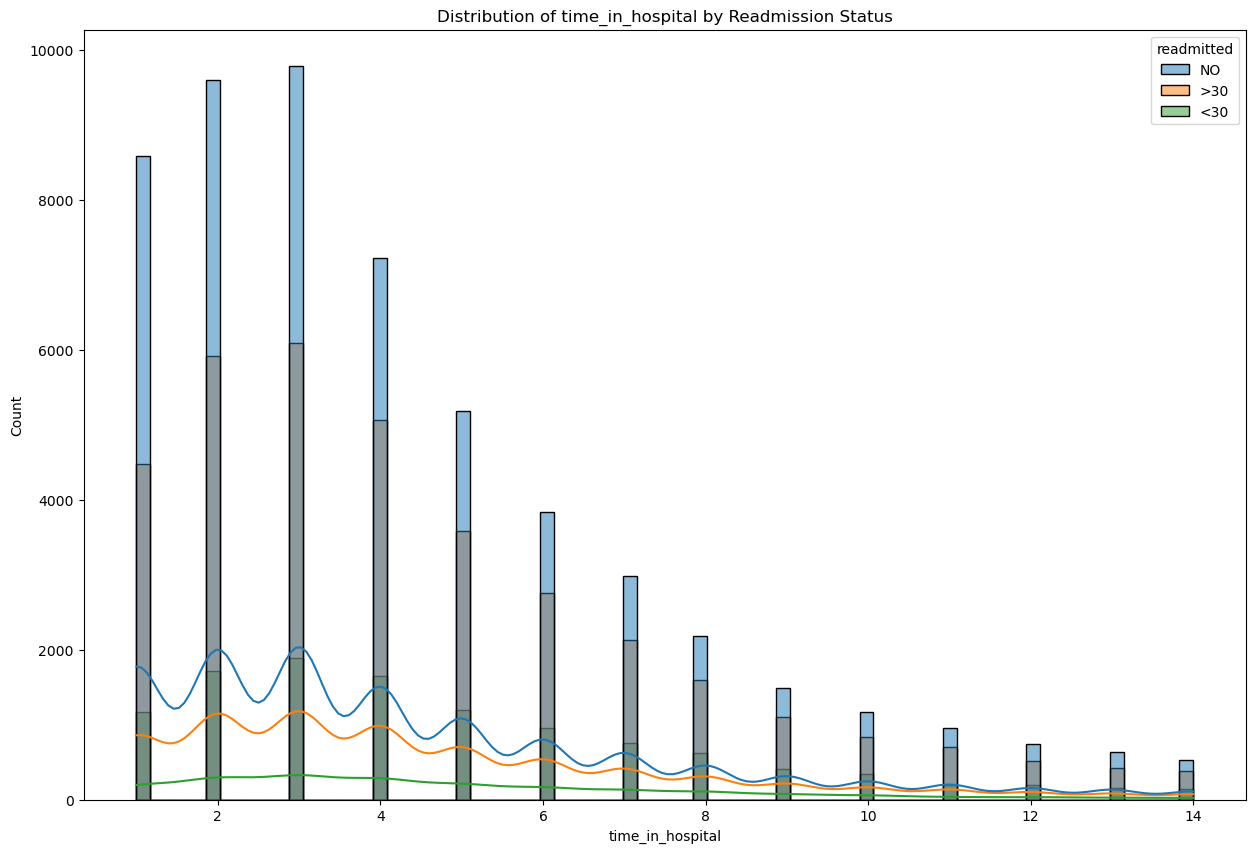

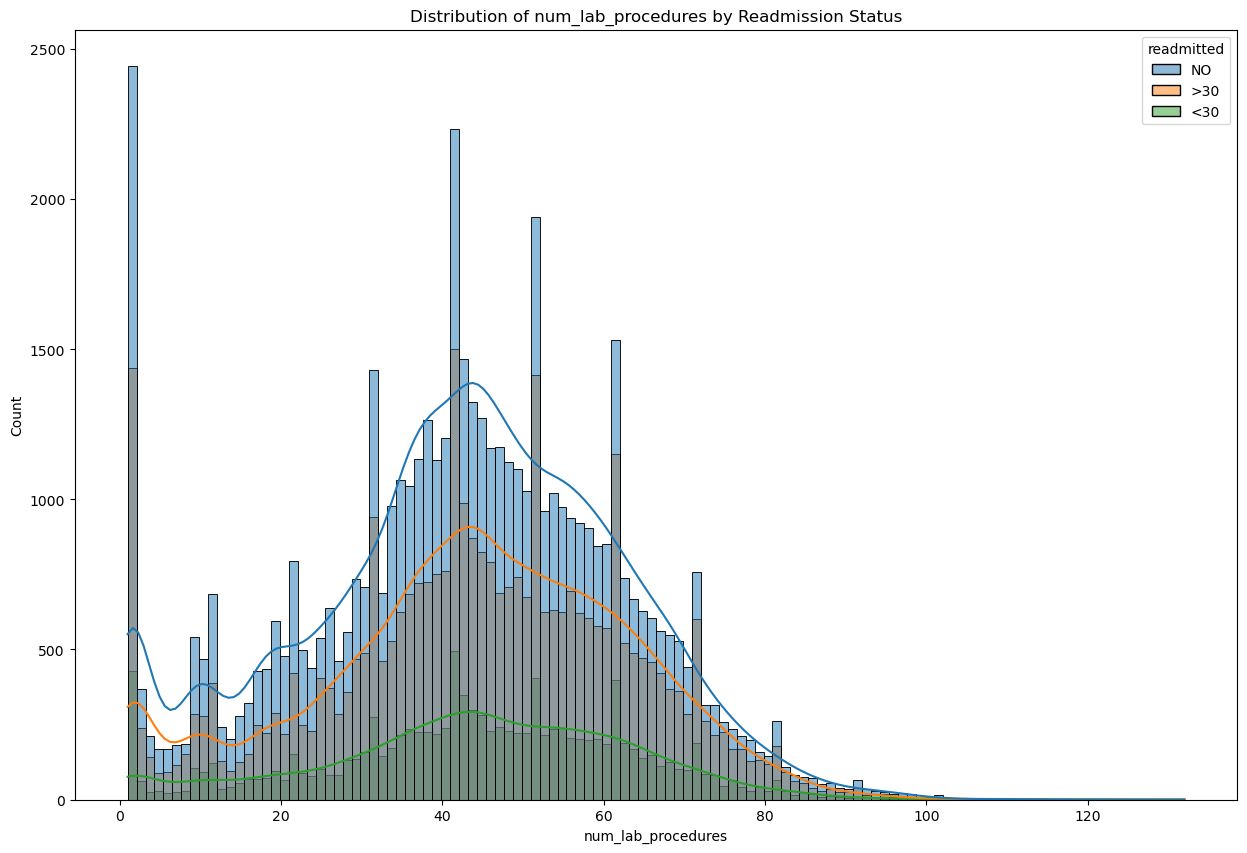

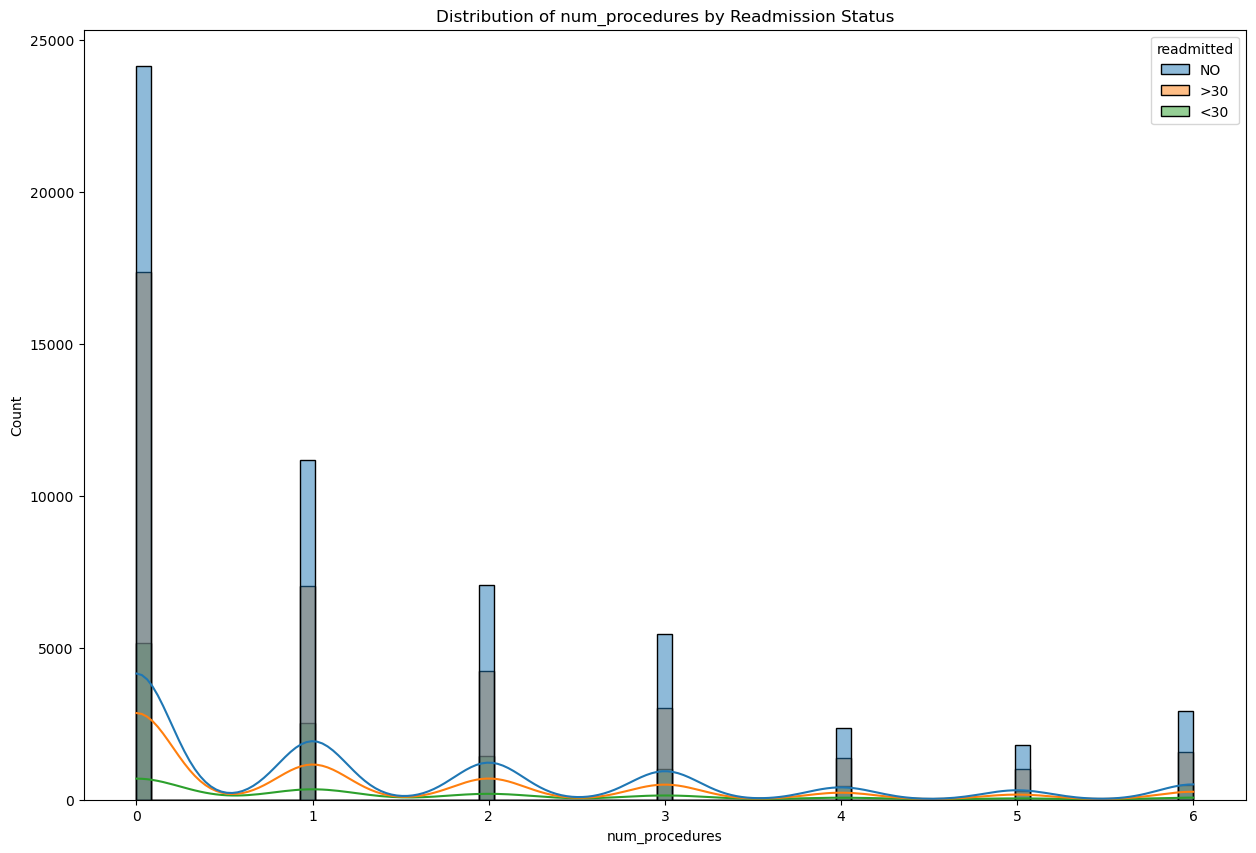

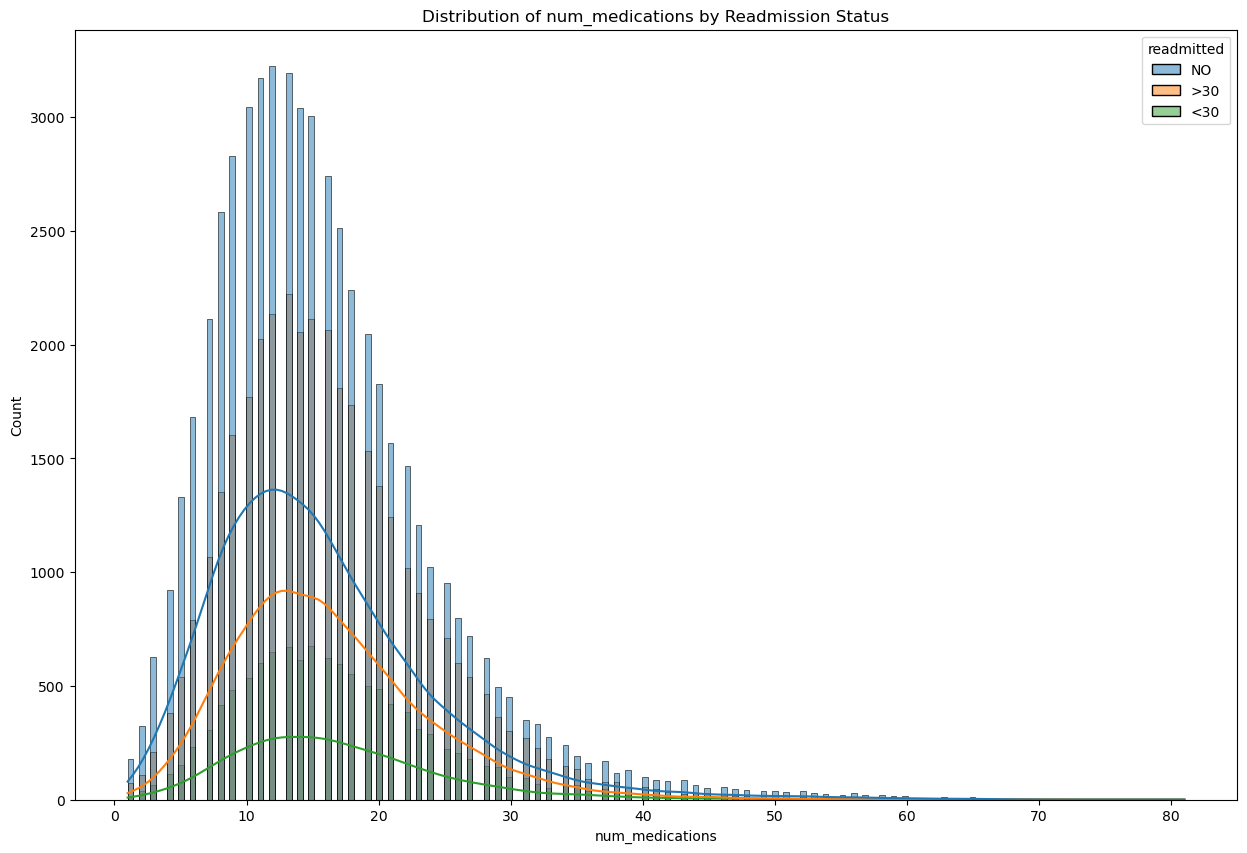

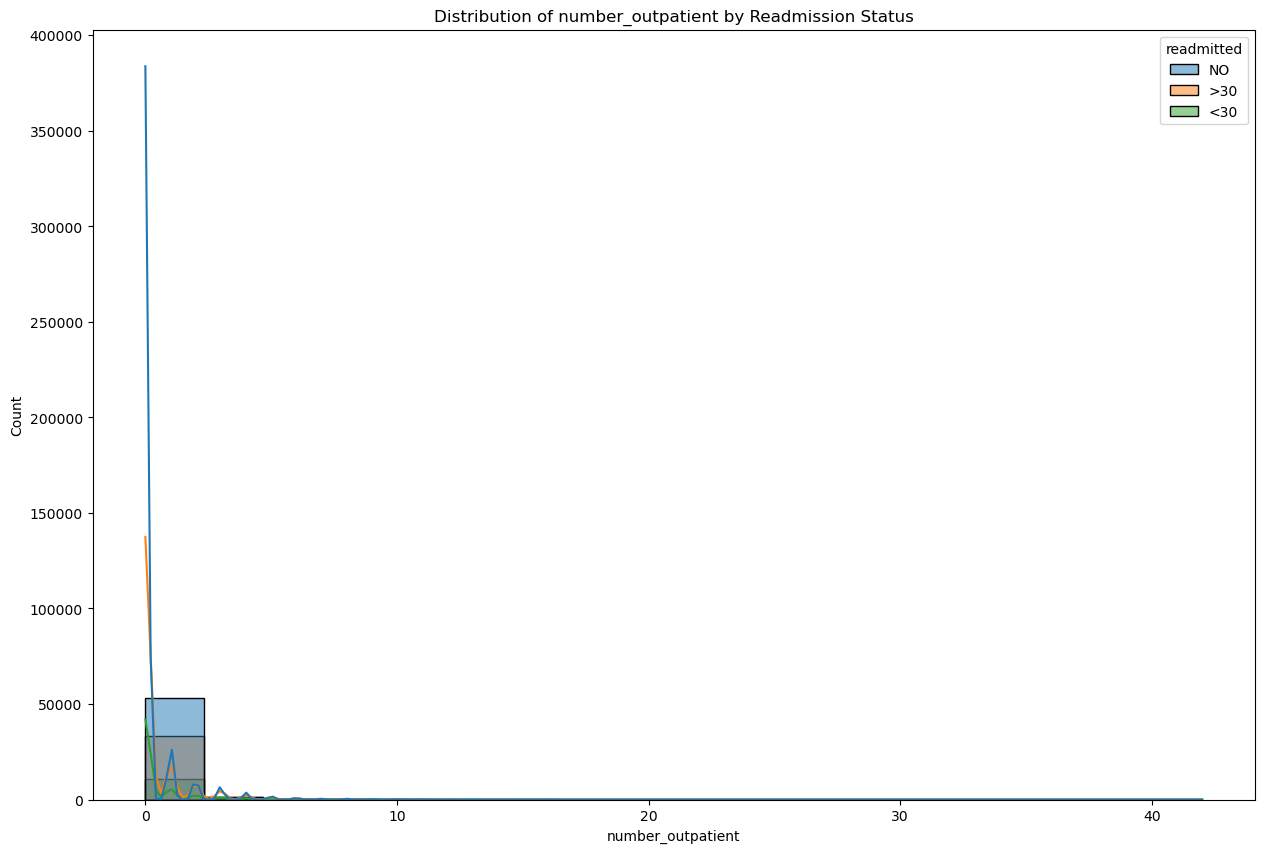

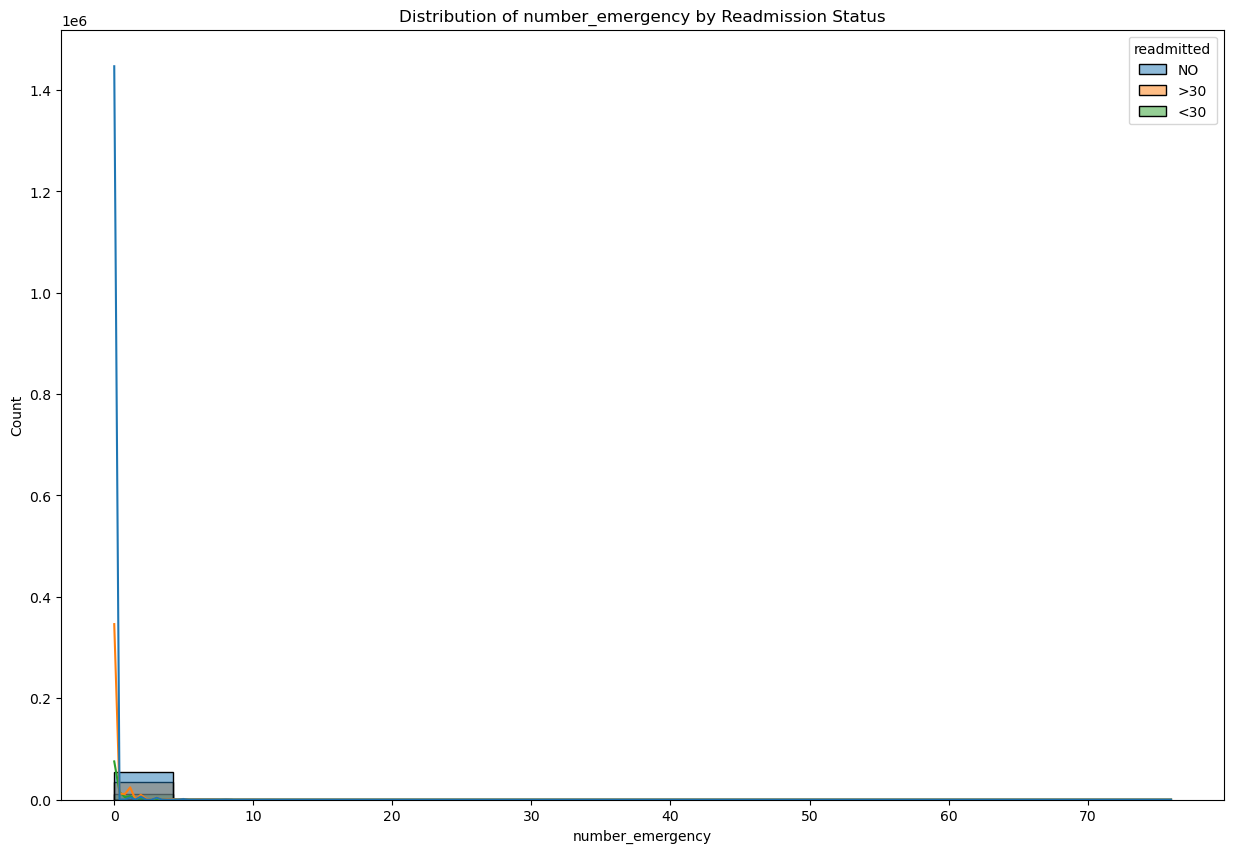

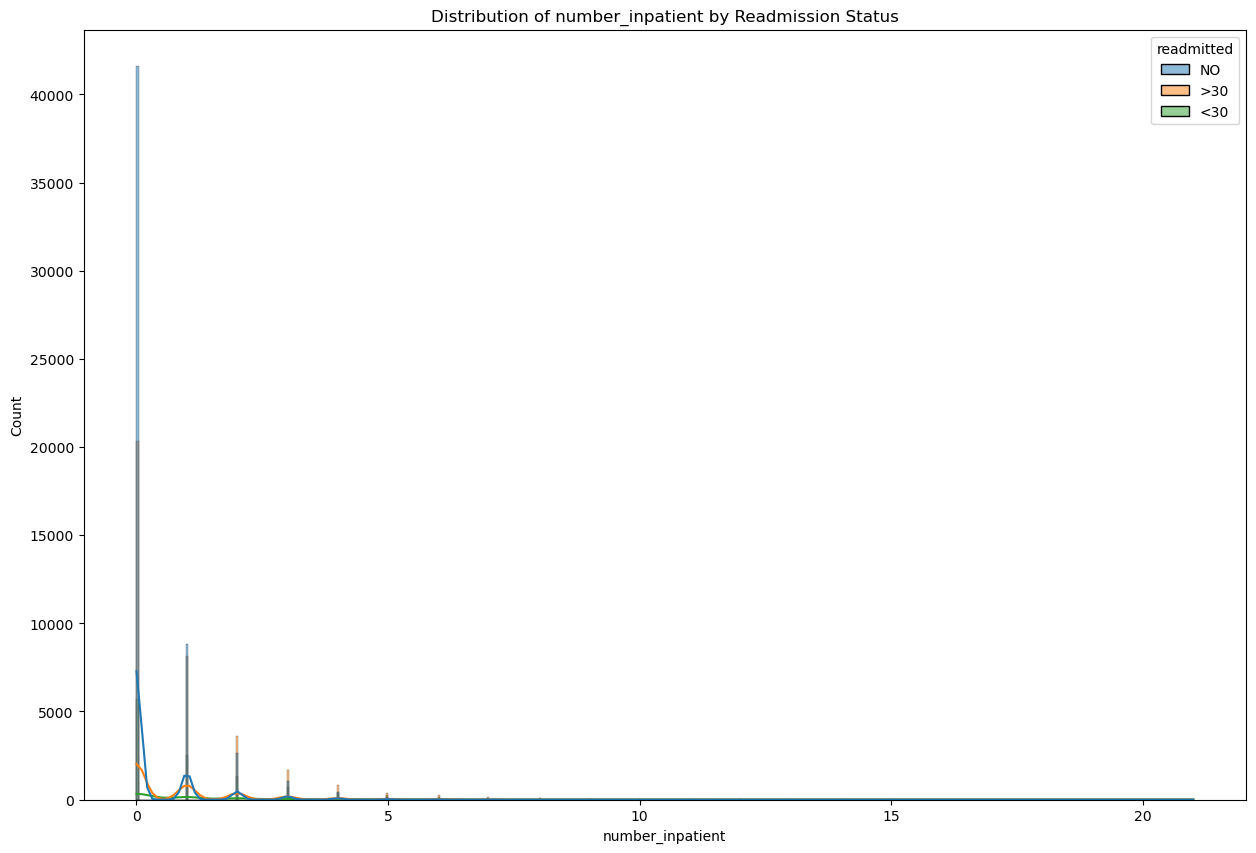

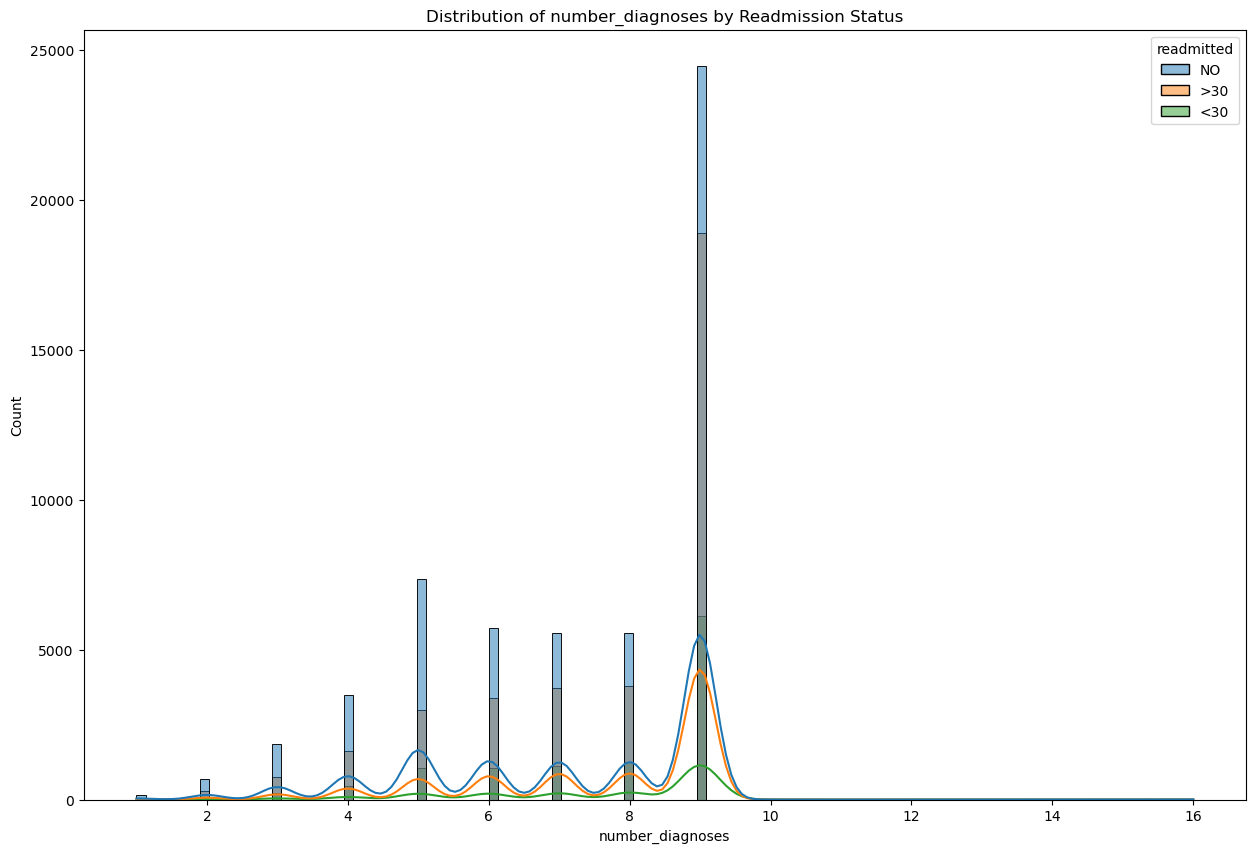

In [6]:
# Seperate out features for visualization
num_features = patient_data.select_dtypes(include='number')
# Irrelevant or categoricall
num_features.drop(['encounter_id', 'patient_nbr', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id'], axis=1, inplace=True)

# Look at numerical feature distributions
for i, col in enumerate(num_features):
    plt.figure(figsize=(15, 10))
    sns.histplot(data=patient_data, x=col, hue='readmitted', kde=True)
    plt.title(f'Distribution of {col} by Readmission Status')

c:\Users\jewbo\anaconda3\envs\reco310\lib\site-packages\pandas\plotting\_matplotlib\core.py:580: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = self.plt.figure(figsize=self.figsize)


<Figure size 1500x1000 with 0 Axes>

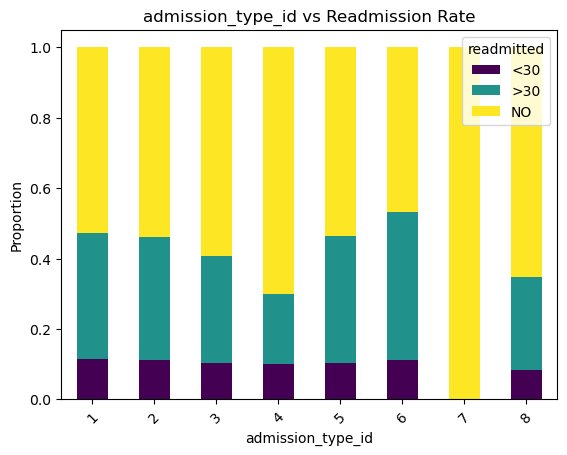

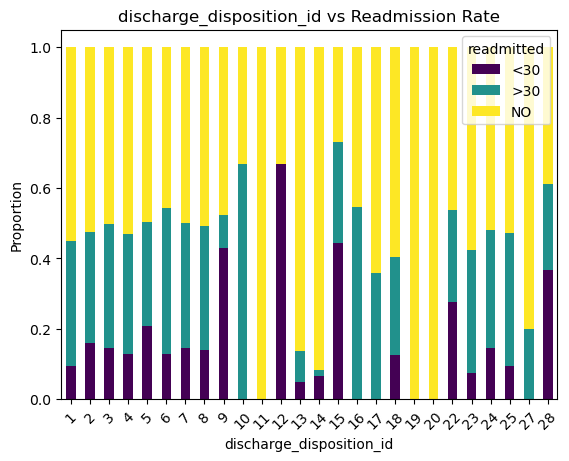

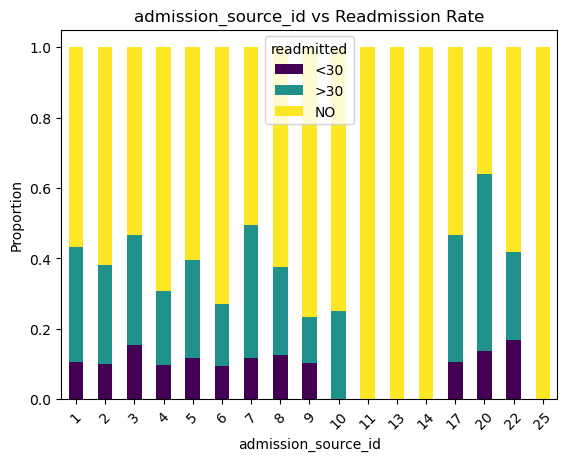

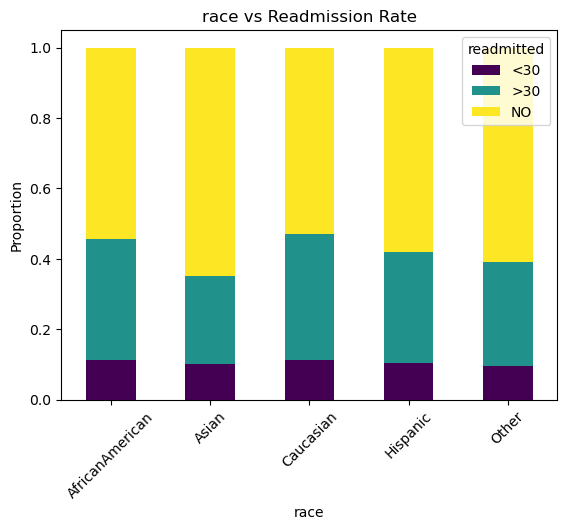

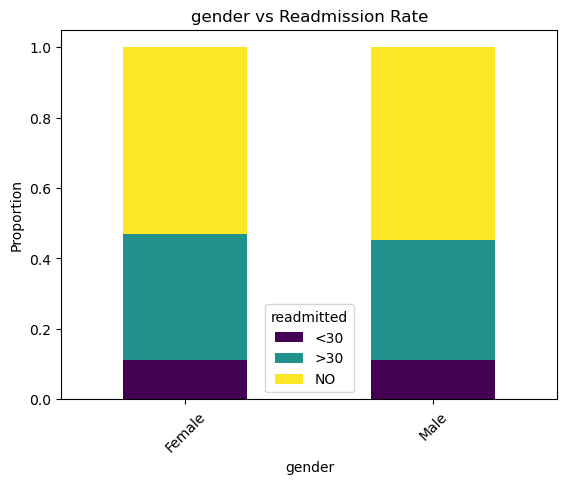

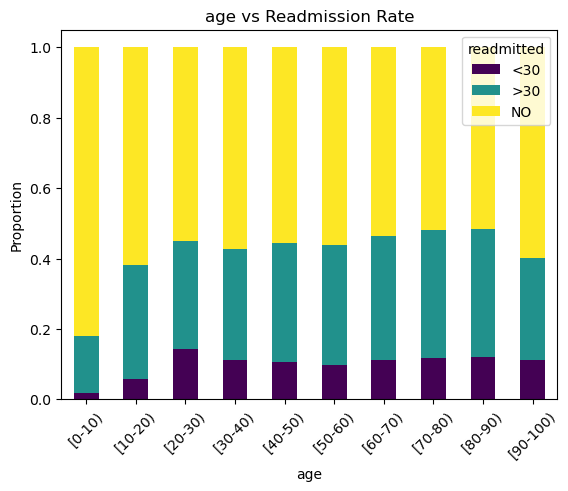

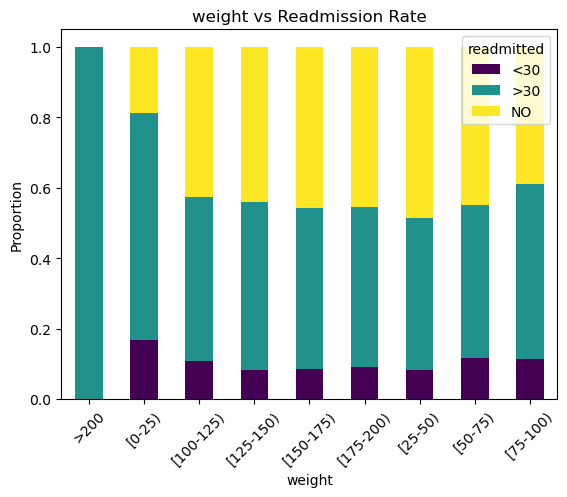

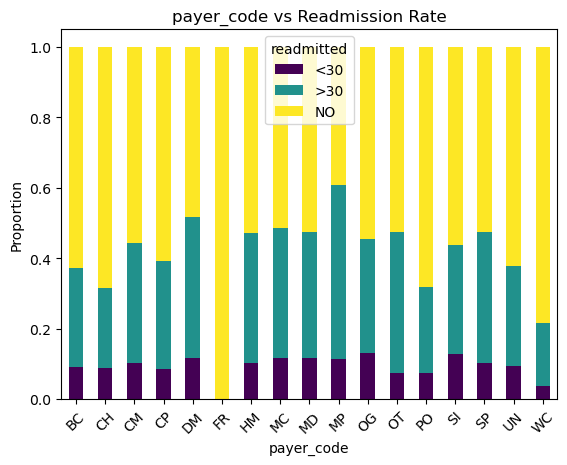

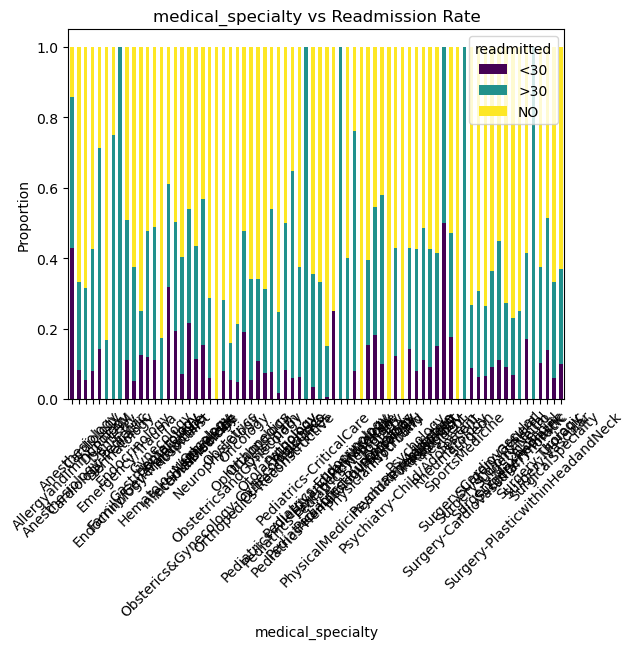

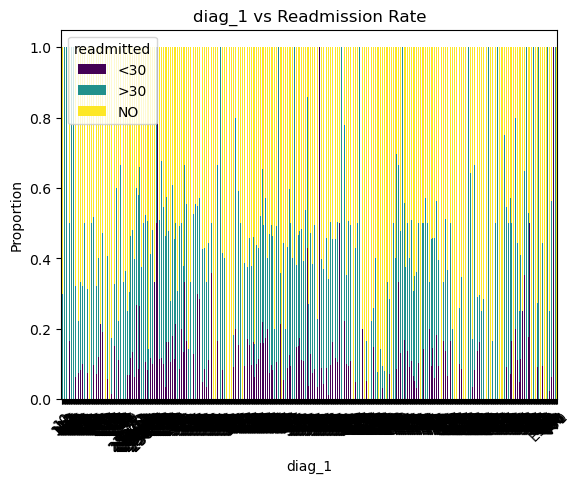

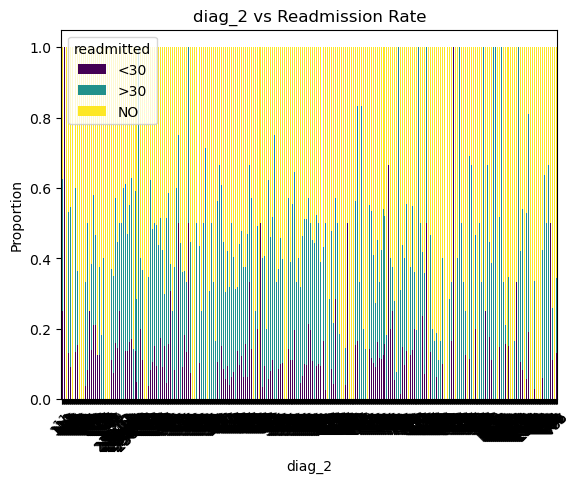

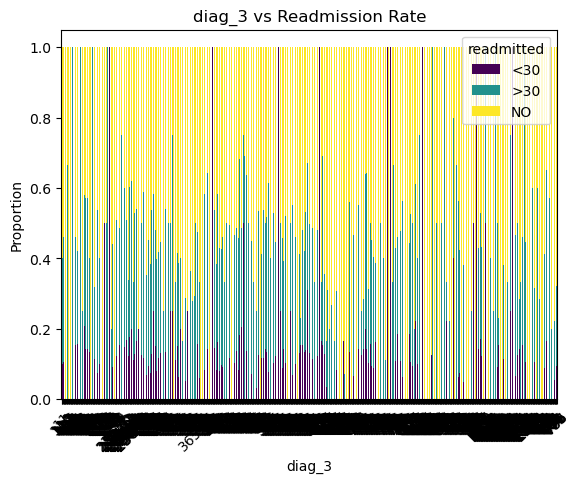

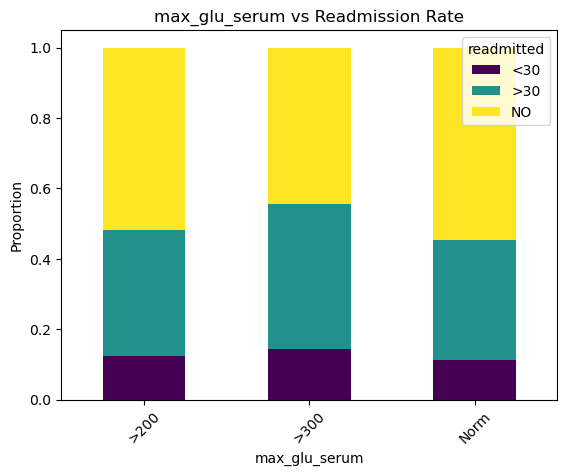

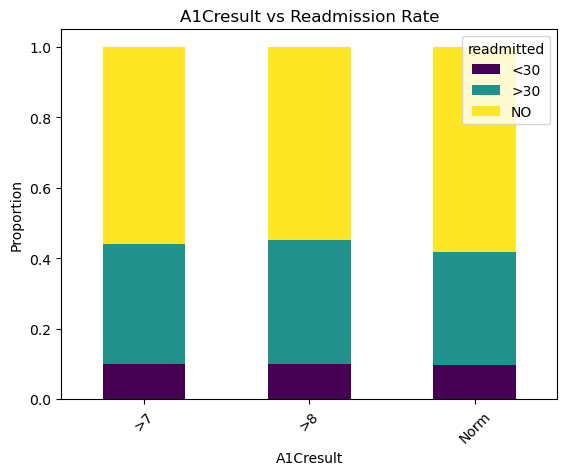

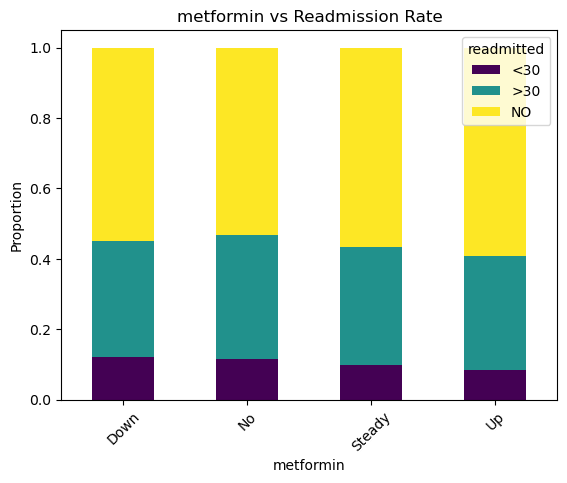

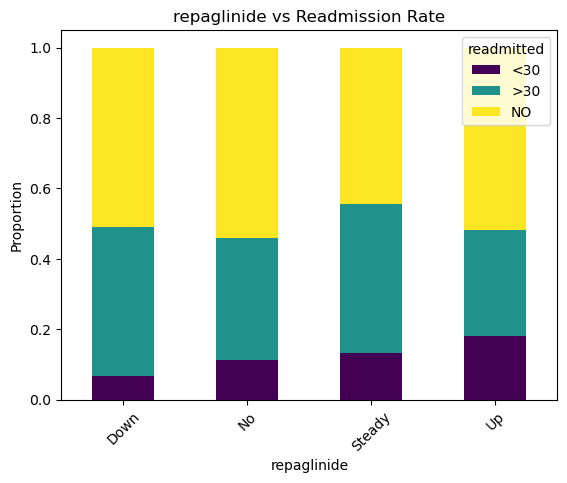

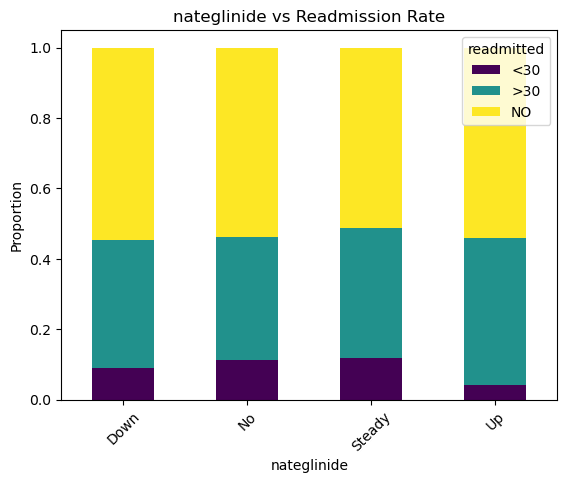

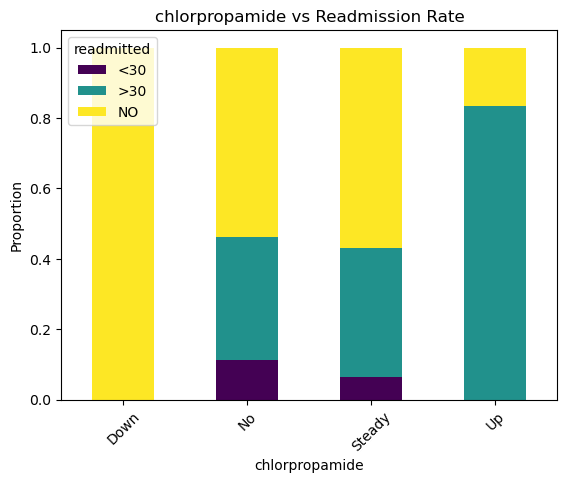

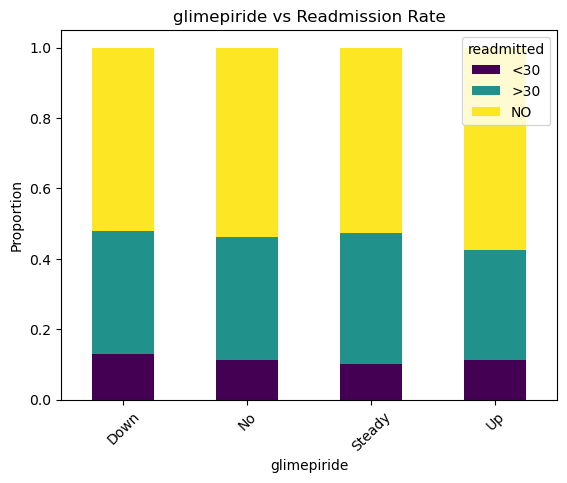

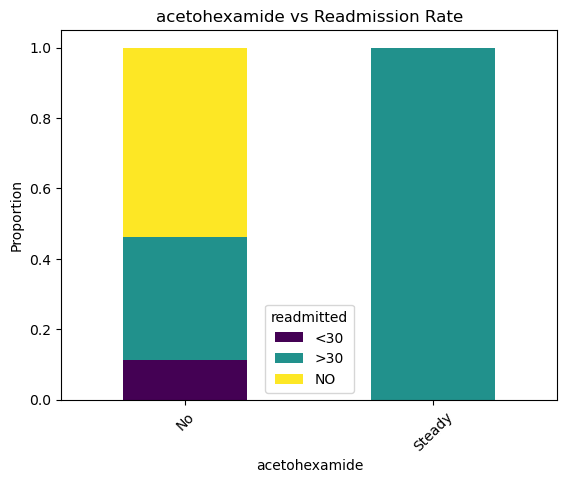

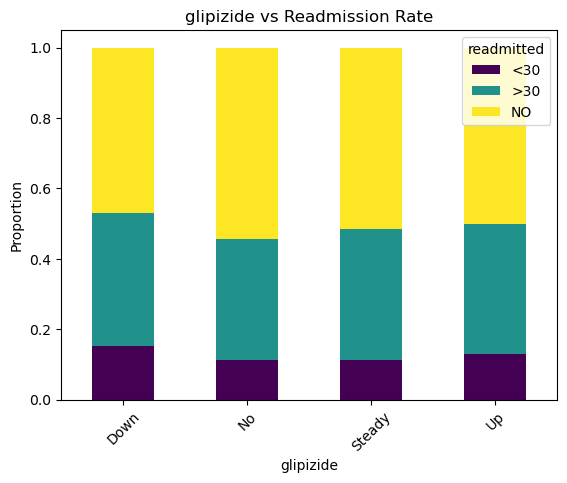

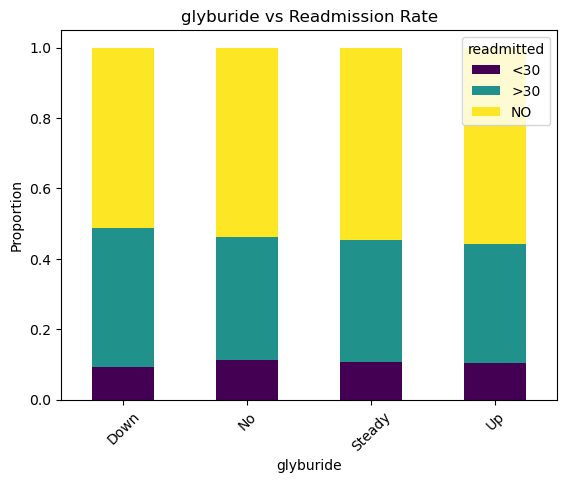

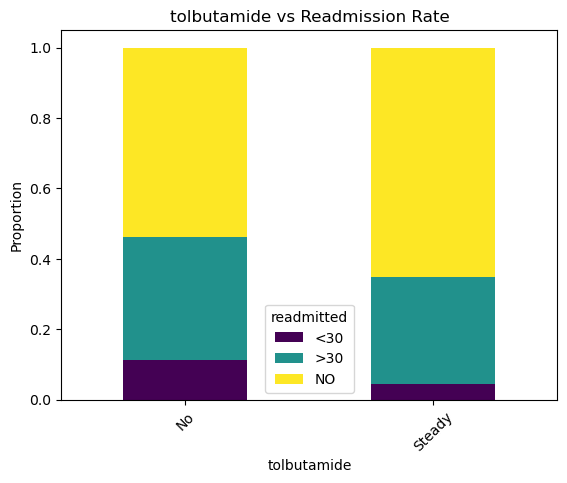

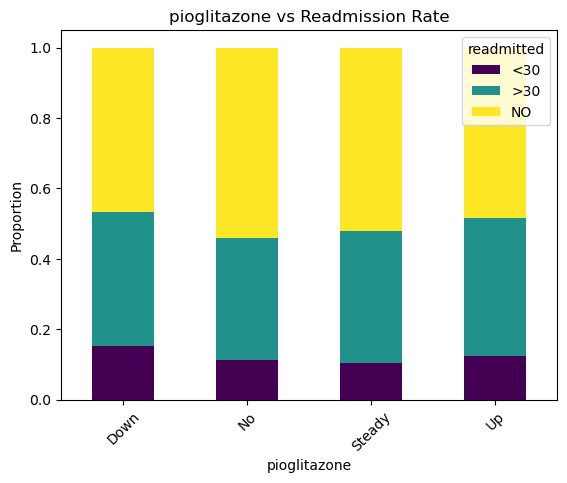

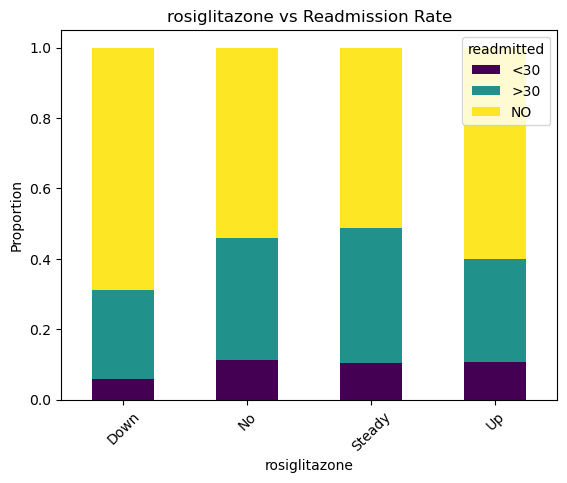

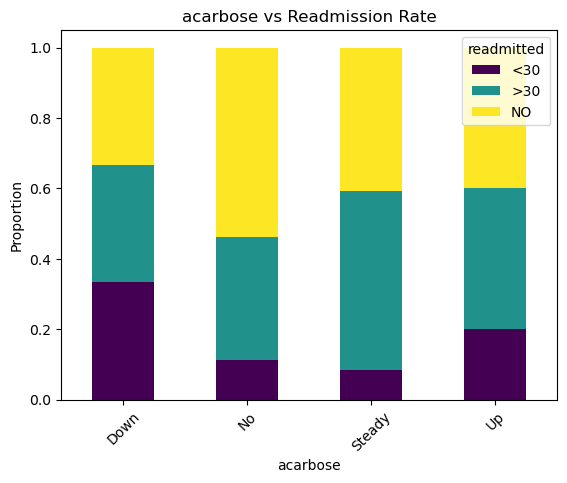

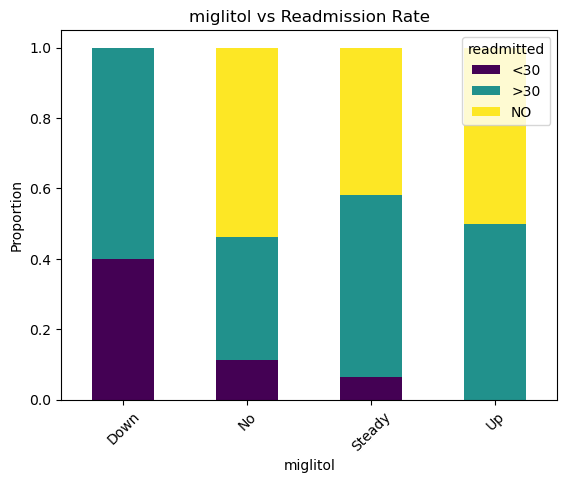

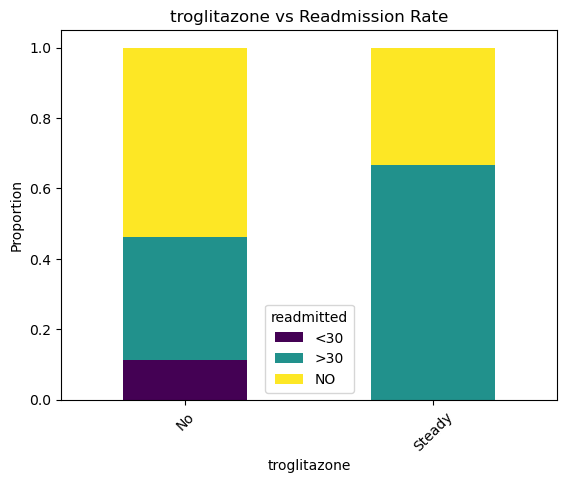

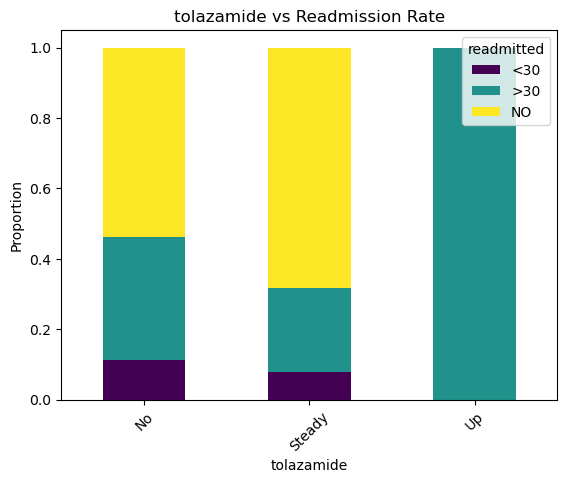

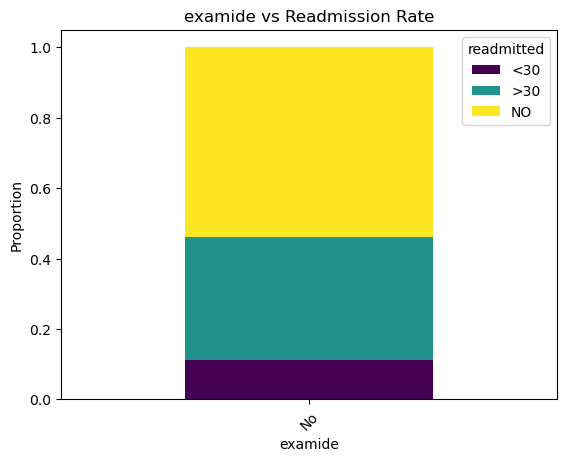

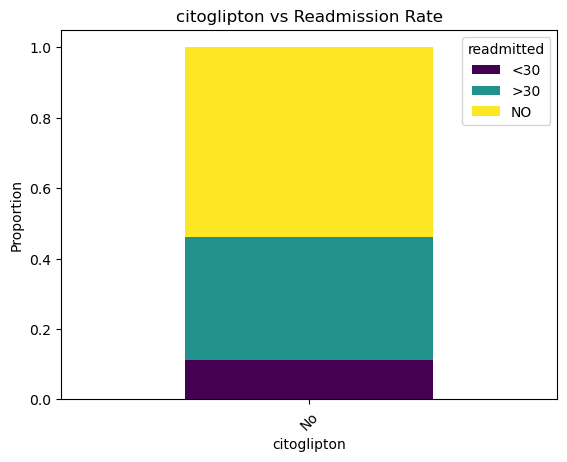

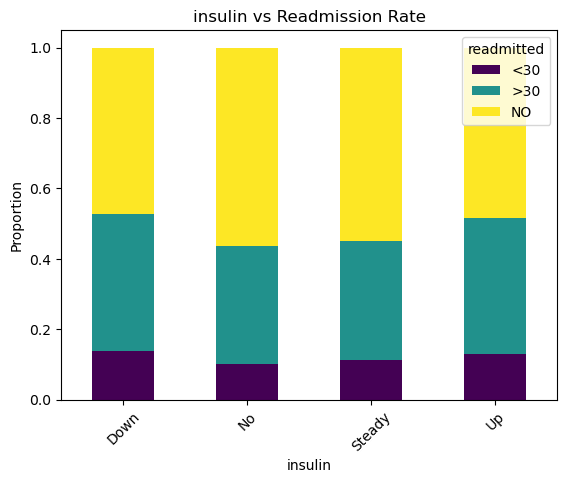

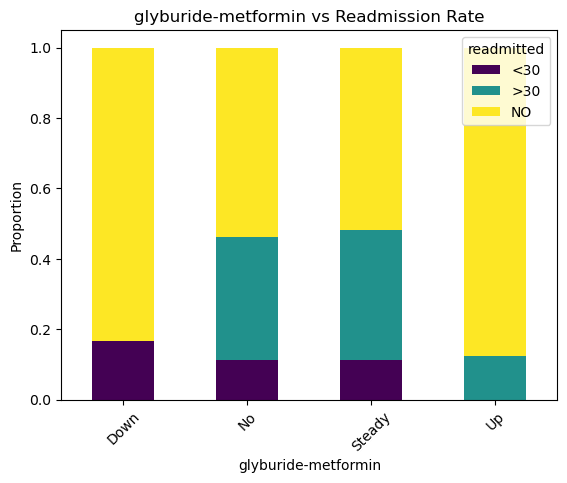

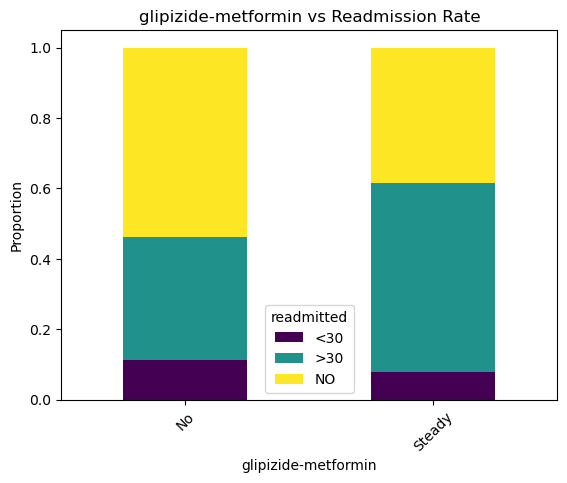

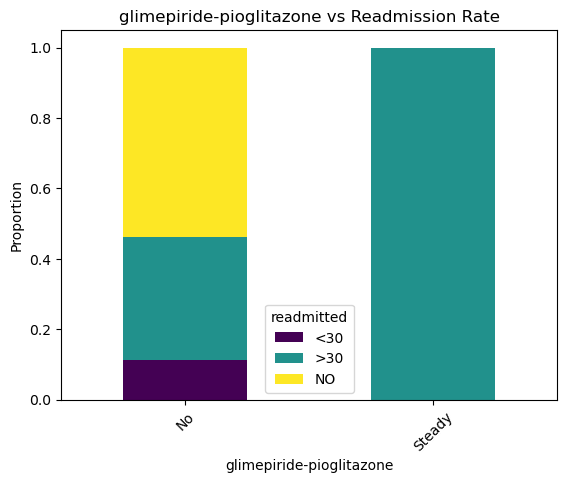

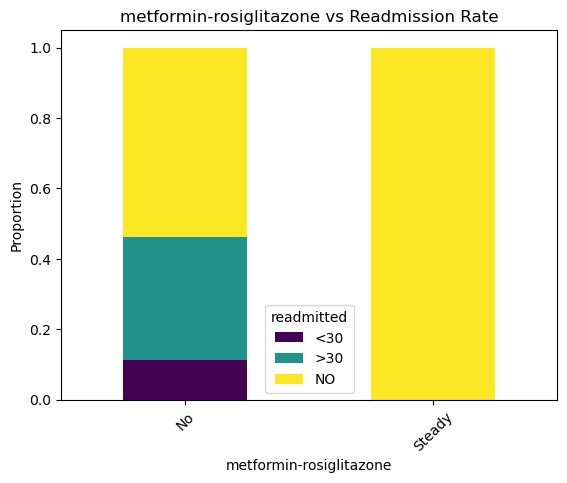

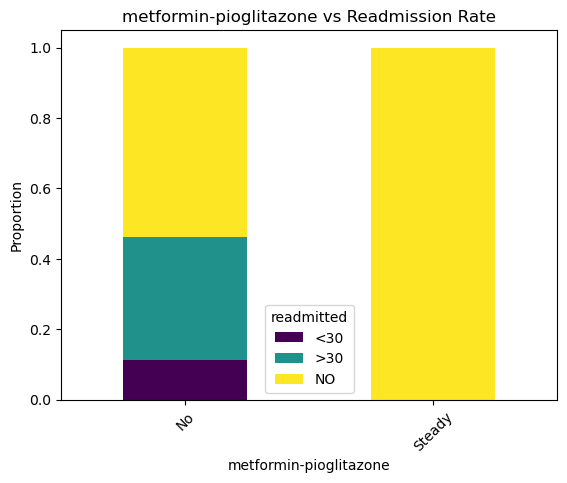

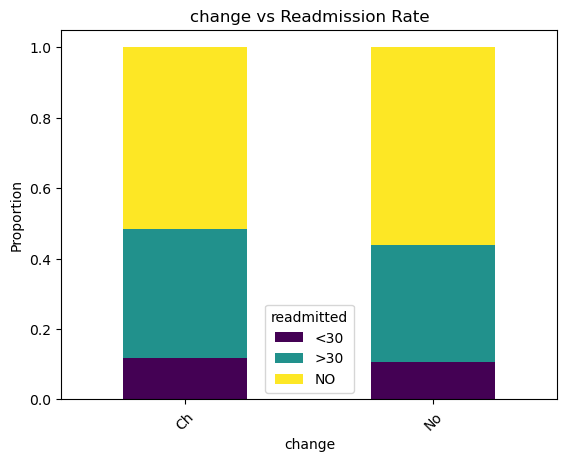

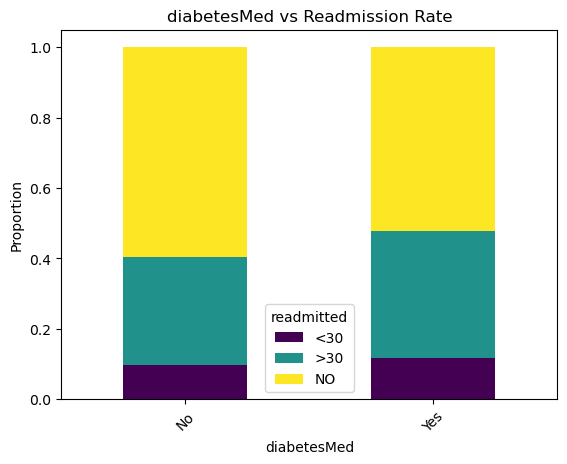

In [7]:
# Seperate out features for visualization
categorical = ['admission_type_id', 'discharge_disposition_id', 'admission_source_id']
cat_columns = patient_data.select_dtypes(include='object')
cat_cols = list(cat_columns.columns)
categorical.extend(cat_cols)
categorical.remove('readmitted')
cat_features = patient_data[categorical]

# Categorical features
plt.figure(figsize=(15, 10))
for i, col in enumerate(cat_features):
    crosstab = pd.crosstab(patient_data[col], patient_data['readmitted'], normalize='index')
    crosstab.plot(kind='bar', stacked=True, colormap='viridis')
    plt.title(f'{col} vs Readmission Rate')
    plt.ylabel('Proportion')
    plt.xticks(rotation=45)

## Part 2: Implement Baseline Model
First you need to prepare the data for modeling



In [8]:
# Prepare data for modeling
# We will look to combine readmission to make this binary
patient_data['readmitted'] = patient_data['readmitted'].map({'<30': 1, '>30': 1, 'NO': 0})

# These columns hold no meaning are just unique identifiers and readmitted is our target
cols_to_drop = ['encounter_id', 'patient_nbr', 'readmitted']
X = patient_data.drop(columns=cols_to_drop)
y = patient_data['readmitted'].astype(int)

# Split data into train, validation, and test sets
from sklearn.model_selection import train_test_split

# First split: 80% train+validation, 20% test
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

# Second split: 75% train, 25% validation (resulting in 60% train, 20% validation, 20% test overall)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val
)

In [9]:
# Run this cell without changes
# Preprocess data with Column Transformer pipeline
# To prevent high dimenstionality we will target encode the diagnosis codes rather than one hot encode
target_encode_cols = ['diag_1', 'diag_2', 'diag_3']
ohe_cols = [col for col in categorical if col not in target_encode_cols]
num_cols = num_features.columns

# Create the preprocessing function
num_pipe = Pipeline(steps=[('impute_num', SimpleImputer(strategy='median')),
                           ('scaler', StandardScaler())])

ohe_pipe = Pipeline(steps=[('impute_cat', SimpleImputer(strategy='constant', fill_value='?')),
                           ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore'))])

tarenc_pipe = Pipeline(steps=[('impute_cat', SimpleImputer(strategy='constant', fill_value='?')),
                              ('tar_encode', TargetEncoder(target_type='binary'))])

col_trans = ColumnTransformer(transformers=[('num', num_pipe, num_cols),
                                            ('cat', ohe_pipe, ohe_cols),
                                            ('tar', tarenc_pipe, target_encode_cols)],
                              remainder='passthrough')

# Need to provide y_train for the target encoder
X_train_pro = col_trans.fit_transform(X_train, y_train)
X_val_pro = col_trans.transform(X_val)
X_test_pro = col_trans.transform(X_test)

print(f"Training set: {X_train_pro.shape} samples")
print(f"Validation set: {X_val_pro.shape} samples")
print(f"Test set: {X_test_pro.shape} samples")

c:\Users\jewbo\anaconda3\envs\reco310\lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [2, 8, 23] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Training set: (61059, 220) samples
Validation set: (20353, 220) samples
Test set: (20354, 220) samples


c:\Users\jewbo\anaconda3\envs\reco310\lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [8, 25, 33] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [10]:
# Create a baseline with two hidden layers, use the relu activation function, select an appropriate number of nodes (64, 32)
# Don't forget your output layer for binary classification
def create_baseline_model(input_dim):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')  # binary output
    ])
    
    model.compile(
        # Use Adam
        optimizer=Adam(learning_rate=1e-3),
        # Select appropriate loss for binary classification
         loss='binary_crossentropy',
        # Evaluate based on recall
        metrics=[tf.keras.metrics.Recall(name='recall'),
                 tf.keras.metrics.Precision(name='precision'),
                 'accuracy']                          # Evaluate based on recall (plus extras for context)
    )
    
    return model

# Create and train the baseline model
baseline_model = create_baseline_model(X_train_pro.shape[1])
baseline_model.summary()

# Train the model without any callbacks
baseline_history = baseline_model.fit(
    X_train_pro, y_train,
    epochs=50,  # Train for a fixed number of epochs
    batch_size=32,
    validation_data=(X_val_pro, y_val),
    verbose=1
)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │        14,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,257 (63.50 KB)

 Trainable params: 16,257 (63.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
1909/1909 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.6311 - loss: 0.6363 - precision: 0.6234 - recall: 0.5038 - val_accuracy: 0.6446 - val_loss: 0.6228 - val_precision: 0.6124 - val_recall: 0.6236
Epoch 2/50
1909/1909 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6478 - loss: 0.6205 - precision: 0.6338 - recall: 0.5586 - val_accuracy: 0.6461 - val_loss: 0.6190 - val_precision: 0.6177 - val_recall: 0.6093
Epoch 3/50
1909/1909 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6526 - loss: 0.6149 - precision: 0.6377 - recall: 0.5703 - val_accuracy: 0.6459 - val_loss: 0.6189 - val_precision: 0.6160 - val_recall: 0.6152
Epoch 4/50
1909/1909 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6573 - loss: 0.6106 - precision: 0.6417 - recall: 0.5807 - val_accuracy: 0.6486 - val_loss: 0.6190 - val_precision: 0.6214 - val_recall: 0.6080
Epoch 5/50
1909/1909 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6611 - loss: 0.6065 - precision: 0.6456 - recall: 0.5868 - val_accuracy: 0.6466 - va

## Part 3: Visualize Training and Validation curves
Important to visualize our training curves in order to understand model limitations and adapt the next iteration. Particularly important to understand the models bias and variance (over/under fitting).

Baseline Test Recall: 0.5271


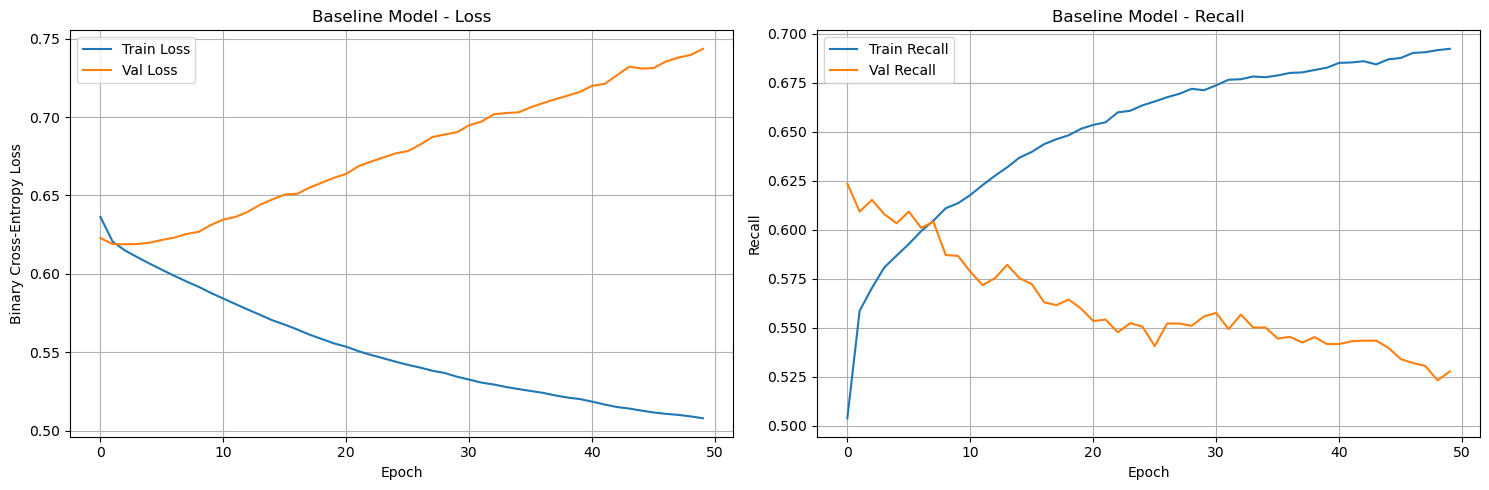

In [11]:
# Evaluate the baseline model on testing data
baseline_test_loss, baseline_test_recall = baseline_model.evaluate(X_test_pro, y_test, verbose=0)[:2]
print(f"Baseline Test Recall: {baseline_test_recall:.4f}")

# Plot the training and validation loss/accuracy curves
def plot_training_history(history, title=''):
    plt.figure(figsize=(15, 5))
    
    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epoch'); plt.ylabel('Binary Cross-Entropy Loss')
    plt.legend(); plt.grid(True)
    
    # Plot recall
    plt.subplot(1, 2, 2)
    plt.plot(history.history['recall'], label='Train Recall')
    plt.plot(history.history['val_recall'], label='Val Recall')
    plt.title(f'{title} - Recall')
    plt.xlabel('Epoch'); plt.ylabel('Recall')
    plt.legend(); plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# Plot baseline model training history
plot_training_history(baseline_history, title='Baseline Model')

## Part 4: Implement Callbacks for Monitoring and Early Stopping

Clear sign of model overfitting and gradient problems. Now, let's implement callbacks to monitor training and prevent overfitting. We will also provide a more complex network to attempt to address the overfitting.

In [12]:
# Implement EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=6,          # give ReduceLROnPlateau time to act (patience=3 there)
    min_delta=1e-3,      # require small improvement
    mode='min',
    restore_best_weights=True,
    verbose=1
)

# Implement ModelCheckpoint callback to save the best model
checkpoint_filepath = './best_model.keras'
model_checkpoint = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    mode='min',
    verbose=1
)

# Implement TensorBoard callback for visualization
log_dir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(
    log_dir=log_dir,
    histogram_freq=1,
    write_graph=True
)

# Don't change this one
from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,        # Reduce learning rate by 80%
    patience=3,        # Wait 5 epochs of no improvement
    min_lr=0.000001,    # Don't go below this learning rate
    verbose=1          # Print when learning rate changes
)

# Combine all callbacks into a list
callbacks = [
    early_stopping,
    model_checkpoint,
    tensorboard_callback,
    reduce_lr
]

In [13]:
# Run this cell without changes
# Create an improved model with gradient problem mitigation strategies and train with callbacks
def create_improved_model(input_dim):
    model = Sequential()
    
    # First layer
    model.add(Input((input_dim,)))
    model.add(Dense(64))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.2))  
    
    # Second layer
    model.add(Dense(32))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.2))
    
    # Output layer
    model.add(Dense(1, activation='sigmoid'))
    
    # Use Adam optimizer with gradient clipping
    optimizer = Adam(learning_rate=0.001, clipvalue=.5)
    
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['recall']
    )
    
    return model

# Create and compile the improved model
improved_model = create_improved_model(X_train_pro.shape[1])
improved_model.summary()

# Train the improved model with the callbacks
improved_history = improved_model.fit(
    X_train_pro, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val_pro, y_val),
    callbacks=callbacks,
    verbose=1
)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 64)             │        14,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,641 (65.00 KB)

 Trainable params: 16,449 (64.25 KB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/100
1895/1909 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6748 - recall: 0.5344
Epoch 1: val_loss improved from None to 0.62707, saving model to ./best_model.keras
1909/1909 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.6522 - recall: 0.5231 - val_loss: 0.6271 - val_recall: 0.4139 - learning_rate: 0.0010
Epoch 2/100
1893/1909 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6306 - recall: 0.5445
Epoch 2: val_loss improved from 0.62707 to 0.62614, saving model to ./best_model.keras
1909/1909 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.6290 - recall: 0.5513 - val_loss: 0.6261 - val_recall: 0.4112 - learning_rate: 0.0010
Epoch 3/100
1892/1909 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6257 - recall: 0.5561
Epoch 3: val_loss improved from 0.62614 to 0.62514, saving model to ./best_model.keras
1909/1909 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.6254 - recall: 0.5575 - val_loss: 0.6251 - val_recall: 0.4097 - learning_rate: 0.0010
Epoch 4/100
1888/1909 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0

## Part 5: Analyze Training Results
Again, it is always important to look at curves. Here we should see way less overfitting and platued losses which tell us the model has gone about as far as it can go with the data at hand.

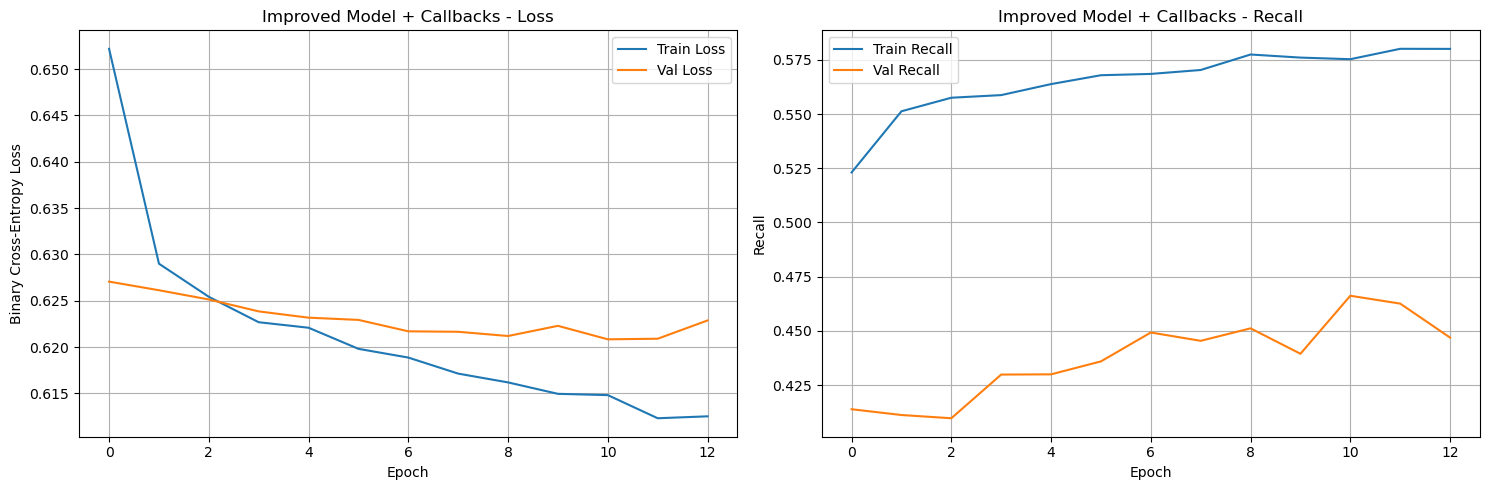

637/637 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.6227 - recall: 0.4496
Improved Model (Final) Test Recall: 0.4496
637/637 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.6215 - recall: 0.4650
Best Model (Checkpoint) Test Recall: 0.4650
Baseline Test Recall: 0.5271
Early Stopping activated at epoch 13 of 100


In [14]:
# Plot the training history with early stopping
plot_training_history(improved_history, title='Improved Model + Callbacks')

# Load the best model saved by ModelCheckpoint
best_model = tf.keras.models.load_model(checkpoint_filepath)

# Evaluate the final improved model
improved_test_loss, improved_test_recall = improved_model.evaluate(X_test_pro, y_test, verbose=1)
print(f"Improved Model (Final) Test Recall: {improved_test_recall:.4f}")

# Evaluate the best model (saved by checkpoint)
best_test_loss, best_test_recall = best_model.evaluate(X_test_pro, y_test, verbose=1)
print(f"Best Model (Checkpoint) Test Recall: {best_test_recall:.4f}")

# Compare with baseline
print(f"Baseline Test Recall: {baseline_test_recall:.4f}")
print(f"Early Stopping activated at epoch {len(improved_history.history['loss'])} of 100")

In [15]:
# Load TensorBoard extension
%load_ext tensorboard

# Launch TensorBoard
%tensorboard --logdir=logs/fit

# Note: TensorBoard output will appear in the notebook
# We can examine histograms of weights and gradients, model graph,
# and other useful visualizations

When training complex machine learning models, the relationship between model complexity and data quality is crucial. Even the most sophisticated neural network architecture can plateau if the loss stops decreasing, indicating that the model has reached the limits of what it can learn from the available data. At this point, rather than adding more layers or parameters, the focus should shift to improving data quality, diversity, and relevance to the specific task. Better data—whether that means more accurate labels, more representative samples, or enhanced feature engineering—often proves more valuable than increased model complexity for breaking through performance plateaus.

## Part 6: Reflection and Documentation

### Question 1: How did early stopping affect the training process and final model performance?

Write Your Answer Here

Early stopping had a number of different effects for the training process and for the final model. When we initiated the early stop, we noticed that the training process halted after epoch 13, this is where generalization peaked, if we were to let the program continue to run, we risk overfitting.

Stopping also gave us a more reliable, better calibrated model. The model's improved probabilities are steadier, which is preferred for clinical use.  

Stopping at 13 epcohs instead of running the full 50 also saves a great deal of time and computational power. 

Overall, early stopping made training more efficient and more generalizable. While it did slightly lower recall at the default cutoff, it is a reasonable trade-off given the ask. 

### Question 2: What patterns did you observe in the training and validation curves?

Write Your Answer Here


Before adding in callbacks a few things emerged. First we notice that training loss decreased steadily, while validation loss hit a minimum around 3 epochs, and then started to rise. This signaled that it was starting to overfit. Training recall climbed, but validation recall was trending downwards, this confirmed that the model was starting to memorize patterns instead of generalizing. 

Once we added the call backs and early stopping we see that the lines, training and validation lines start to level out near each other, this tells us that the model is starting to generalize well.

The more we trained the more we started to see the model miss some recalls, however we traded in the steady, not so flashy performance giving us a solid model, while avoiding a model the is overfiitting and just memorizing data. 

### Question 3: In a healthcare context like this one, why is it particularly important to prevent overfitting?

Write Your Answer Here

### Question 4: How would you explain the benefits of your monitoring approach to non-technical healthcare staff?

Write Your Answer Here

3. Overfitting is particularly important to avoid in healthcare contexts like this one for many reasons. First of all, the consequences of a false negative, (misdiagnosis) carries huge risks for the patience and the overall medical team that missed it. On the other hand a false positive, while still scary and not fun, is much easier to navigate and deal with.
Along with just the overall patient safety and care, there could be a lot of other fallout with a model that is overfit. It carries with it the implicit or interpreted weight of bias. Inaccurate correlations like zipcodes, income or other career types, can be “learned” and amplify disparities when the model meets new patients. Case managers, home-health referrals, and follow up appointments are limited, an overfit model can misdirect scarce resources away from the people who truly need them.

4.Explaination to non-technical health care staff:

Our goal was to make our readmission risk predictions more reliable and resource-efficient, so care teams can trust the alerts they receive.
through the training of the model, watching its learning curves we were able to make sure that our model was not just memorizing old patient charts, but able to actually predict the liklihood of patience that will be readmitted. 

What this will do is allow more time and resources for those that need it the most. There will be less surprises and staff can more appropriatly plan, with confidence, their workload and time management. 

Moving forward:
While there is no such thing as a model that is 100% accurate in forecasting, we promise to continue to monitor, update and fine tune our system as more data comes in, from our patience and we just as importanlty from fellow staff members. All this information will turn this good model into a great model, and it will help us remain a leader in the healthcare industry. 




  

## Summary of Implemented Techniques

In this lab, we've implemented and demonstrated several key techniques for improving neural network training:

1. **Early Stopping**: Automatically halts training when validation performance stops improving, preventing overfitting and saving computational resources.

2. **Model Checkpointing**: Saves the best-performing model during training, ensuring we retain the optimal weights even if training continues past the ideal point.

3. **Training Visualization**: Using TensorBoard and custom plotting functions to monitor and interpret the training process in real-time.

4. **BatchNormalization**: Stabilizes the distribution of layer inputs during training, helping to prevent vanishing/exploding gradients.

5. **Gradient Clipping**: Limits the size of gradient updates to prevent unstable training.

6. **Advanced Activation Functions**: Using LeakyReLU instead of standard ReLU to prevent "dead neurons" and improve gradient flow.

8. **Dropout**: Randomly deactivating neurons during training to prevent overfitting and improve generalization.

By combining these techniques, we were able to improve model performance and training stability if only minorly, resulting in a more reliable patient readmission prediction model that would perform better in real-world healthcare settings. Ultimately, because our final model is accounting for potential issues and still not performing as well as we hoped, it becomes a matter of needing better and more data to predict readmission.

These monitoring and optimization techniques are applicable across a wide range of deep learning applications, not just healthcare, and should be considered essential components of any robust deep learning workflow.